This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [9]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

In [10]:
%matplotlib notebook

In [11]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments1'
imageroot = '20190802_case1.2'
Calibrationfile = '../Case1.1 (calibration)/Calibration.nml'

C:\Users\kayde\OneDrive\Desktop\Ice 2020 Git Hub\crystals\2019-08-02\case1.2
\kayde\OneDrive\Desktop\Ice 2020 Git Hub\crystals\2019-08-02\case1.2


In [12]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments1_retrieved.npz
Segments1_roughness.jpg
Segments1_roughness.txt


In [13]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [14]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/20190802_case1.2-A.bmp
SEMimages/20190802_case1.2-B.bmp
SEMimages/20190802_case1.2-C.bmp
SEMimages/20190802_case1.2-D.bmp
Filename, dx and dy SEMimages/20190802_case1.2-D.bmp 0.6614583 0.6614583


In [15]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 8.864582560183331
Correlation of detectors A-D for each segment
for segment  0
nx= 36
ny= 36
0 1 2.1755281591899274
0 2 1.247472233206679
0 3 14.386047439150094
1 2 18.32372623582913
1 3 -15.788666917786683
2 3 -3.220431923756325
Correlation score = 28.43694073995127



<IPython.core.display.Javascript object>


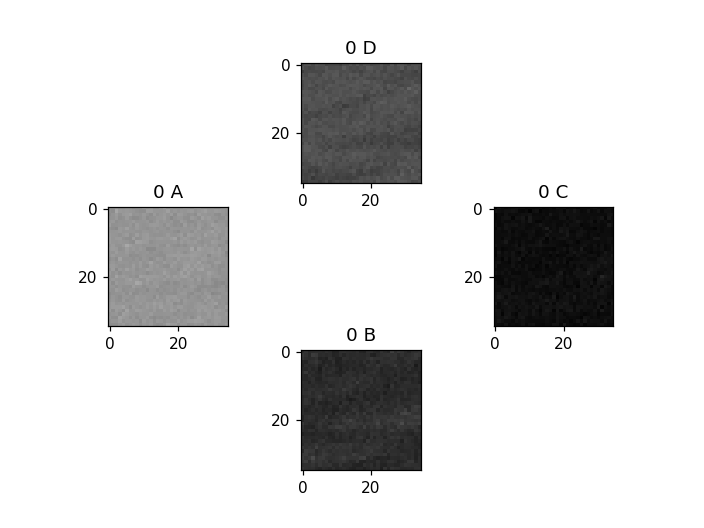

for segment  1
nx= 36
ny= 36
0 1 2.3375294983873673
0 2 -3.178270177993493
0 3 15.492785461985296
1 2 18.27395320820241
1 3 -24.85605383737851
2 3 0.44546936258571207
Correlation score = 34.74983551078321



<IPython.core.display.Javascript object>


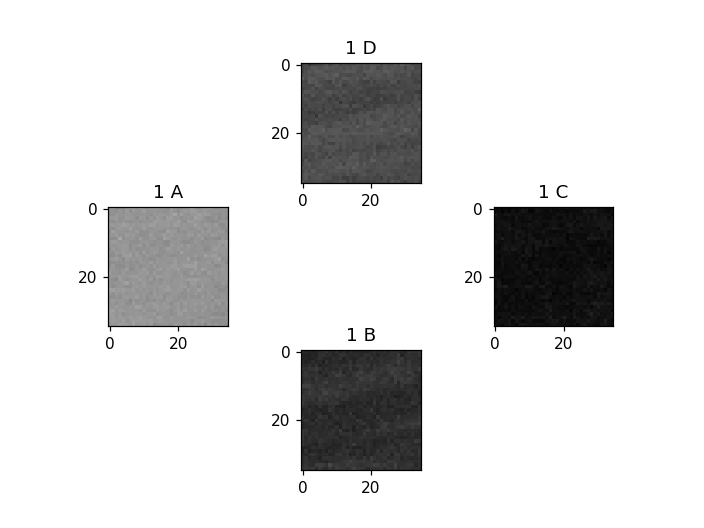

for segment  2
nx= 36
ny= 36
0 1 3.8854422893362504
0 2 4.706109576009138
0 3 11.290933668069336
1 2 18.01569895482681
1 3 -24.023786102376896
2 3 -6.958267179375269
Correlation score = 33.3894369806558



<IPython.core.display.Javascript object>


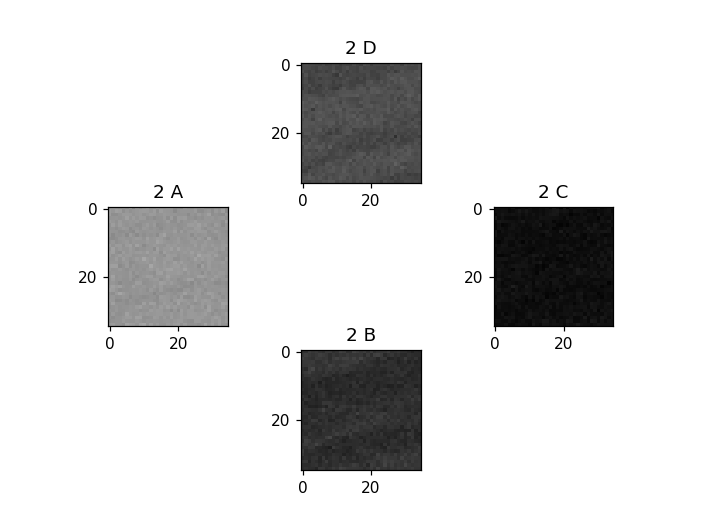

for segment  3
nx= 36
ny= 36
0 1 7.848732374412844
0 2 -1.1884606860813491
0 3 9.092360803416838
1 2 14.93550012007652
1 3 -16.827335878259564
2 3 6.703422525262166
Correlation score = 26.397922907224867



<IPython.core.display.Javascript object>


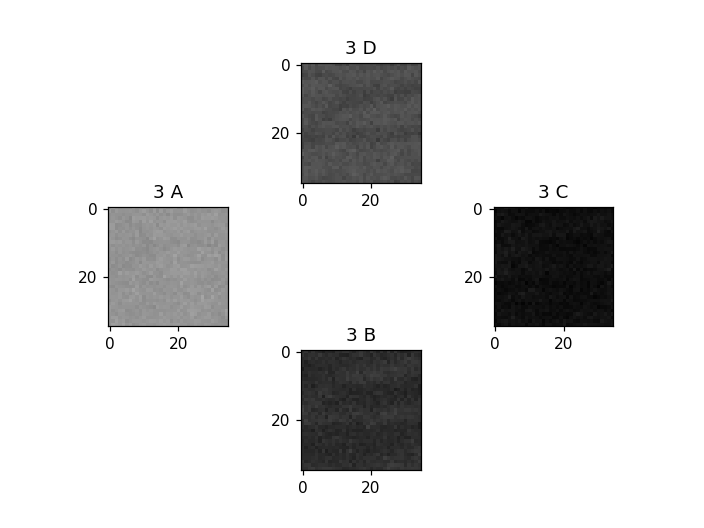

for segment  4
nx= 36
ny= 36
0 1 12.425078885718477
0 2 5.577579981503602
0 3 7.935371272312524
1 2 8.92146238905805
1 3 -17.380413702057986
2 3 5.517259094886661
Correlation score = 25.701624861669963



<IPython.core.display.Javascript object>


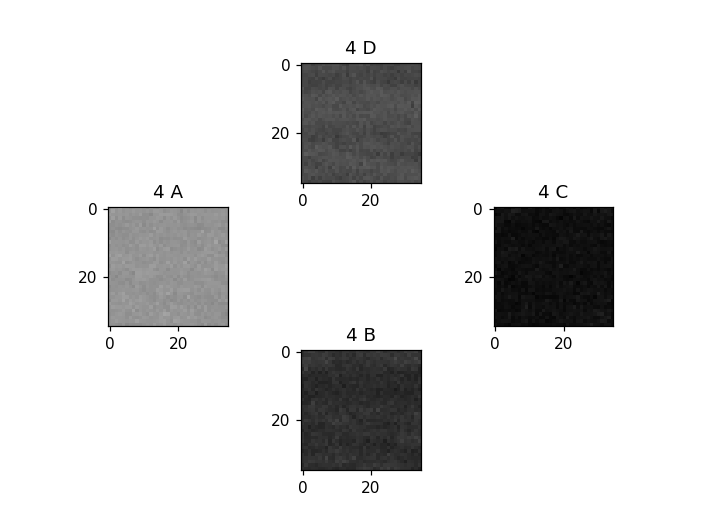

for segment  5
nx= 36
ny= 36
0 1 5.07052124739395
0 2 -4.708404064042968
0 3 7.619594367357909
1 2 13.724758132776444
1 3 -19.224059486492585
2 3 3.3304867778967906
Correlation score = 25.98005127005731



<IPython.core.display.Javascript object>


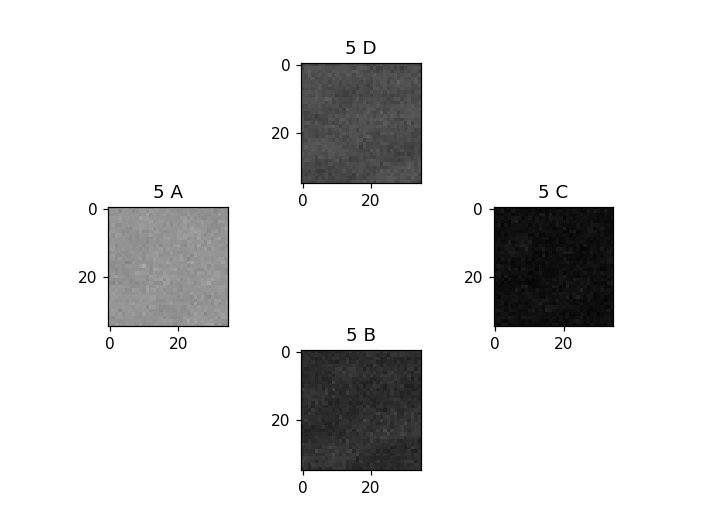

for segment  6
nx= 36
ny= 36
0 1 3.145504021377073
0 2 0.10439341260183477
0 3 16.494973329057242
1 2 24.128080964994787
1 3 -10.174592353827906
2 3 3.2666221201524346
Correlation score = 31.278533842800083



<IPython.core.display.Javascript object>


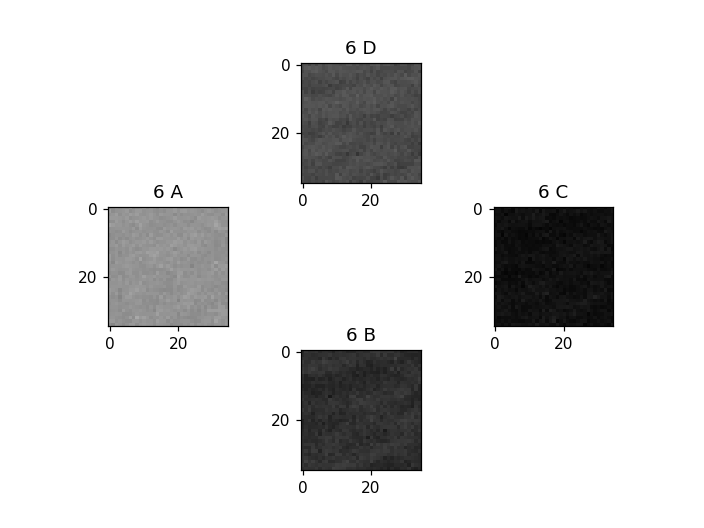

for segment  7
nx= 36
ny= 36
0 1 7.701528839437659
0 2 -1.4509274560671237
0 3 7.033309071902356
1 2 17.973823425718486
1 3 -23.750774191738184
2 3 -0.0549891273549501
Correlation score = 31.591878711123428



<IPython.core.display.Javascript object>


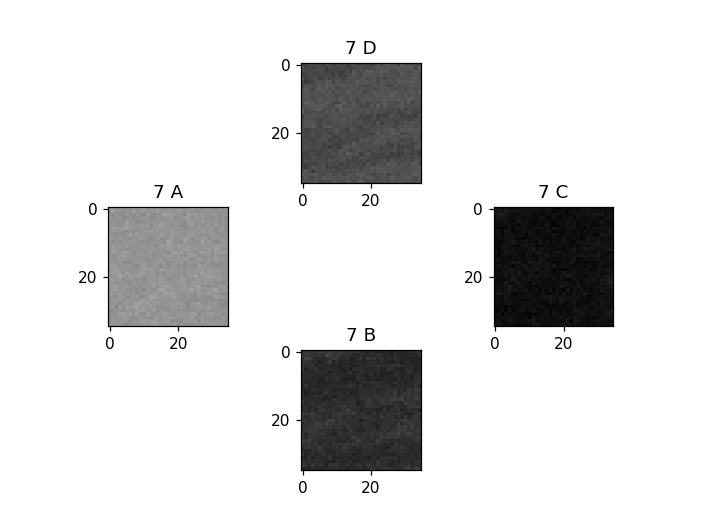

for segment  8
nx= 36
ny= 36
0 1 4.614961959008306
0 2 -4.382164870667421
0 3 14.742899758468347
1 2 19.900111772370234
1 3 -6.549132670078469
2 3 9.699859465906272
Correlation score = 28.122005566219855



<IPython.core.display.Javascript object>


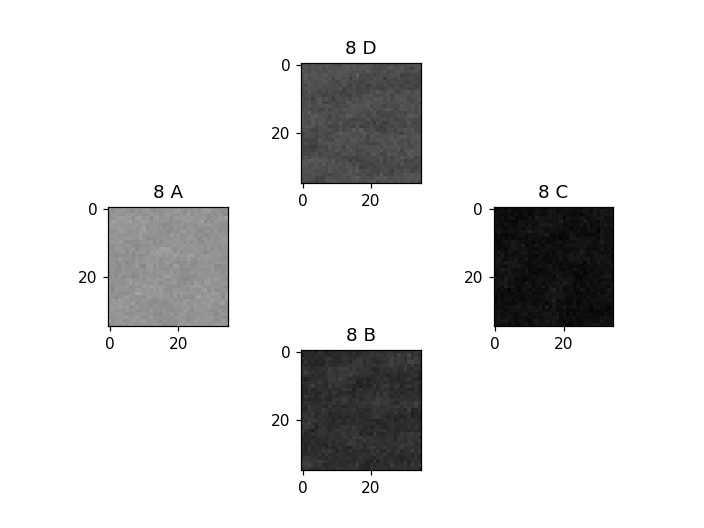

for segment  9
nx= 36
ny= 36
0 1 0.8640442574218384
0 2 -5.340710946787491
0 3 13.217212523190728
1 2 18.5641901591998
1 3 -18.15197434271988
2 3 0.6395007514354498
Correlation score = 29.63944606088122



<IPython.core.display.Javascript object>


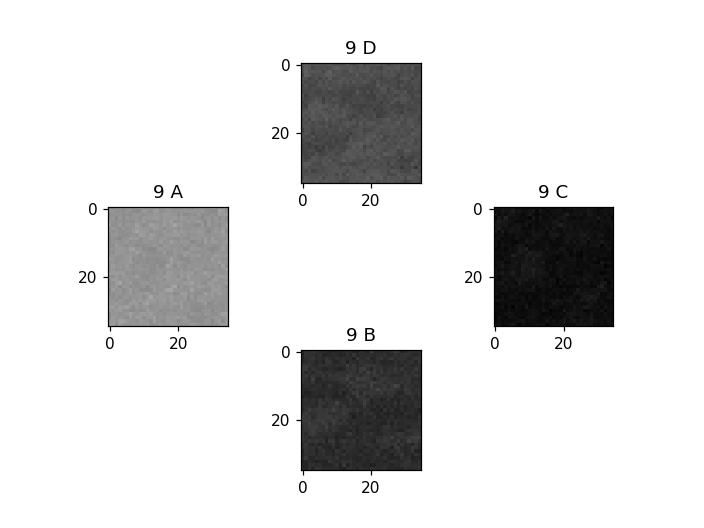

for segment  10
nx= 36
ny= 36
0 1 2.4270980619410505
0 2 -5.2172411114290265
0 3 12.13728028918678
1 2 11.160432630506596
1 3 -12.33218024164931
2 3 4.279651003923356
Correlation score = 21.803149345067773



<IPython.core.display.Javascript object>


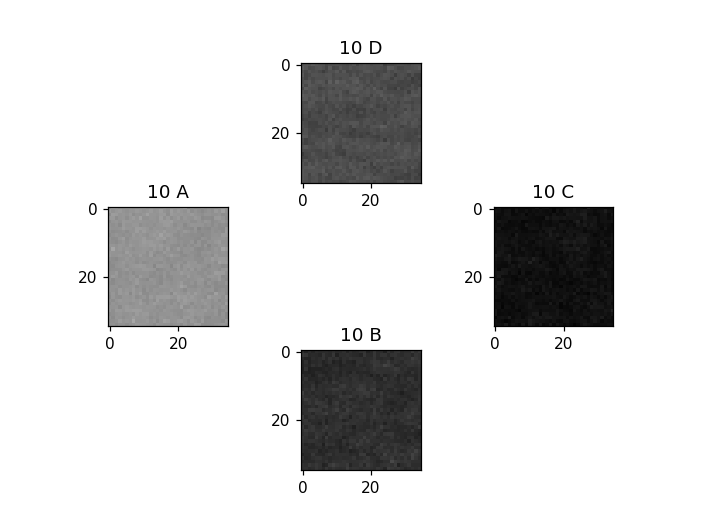

for segment  11
nx= 36
ny= 36
0 1 11.480374393496673
0 2 -2.7446703121421914
0 3 11.14931587453058
1 2 11.681839961910928
1 3 -10.657452265611338
2 3 8.029184908549402
Correlation score = 24.04483187282517



<IPython.core.display.Javascript object>


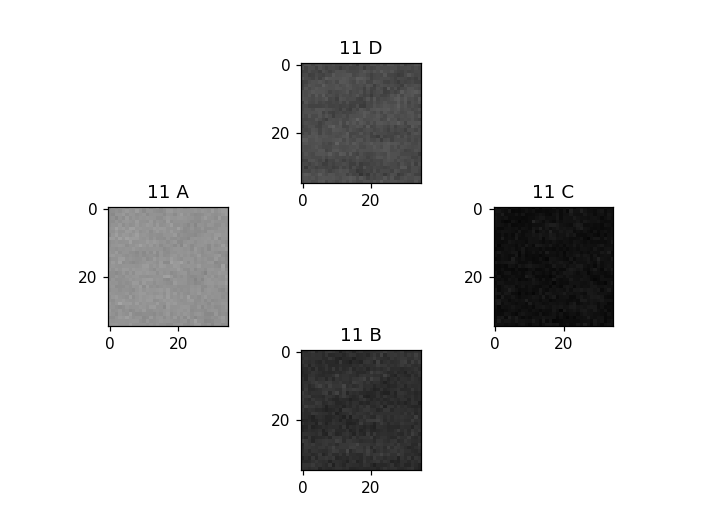

<IPython.core.display.Javascript object>


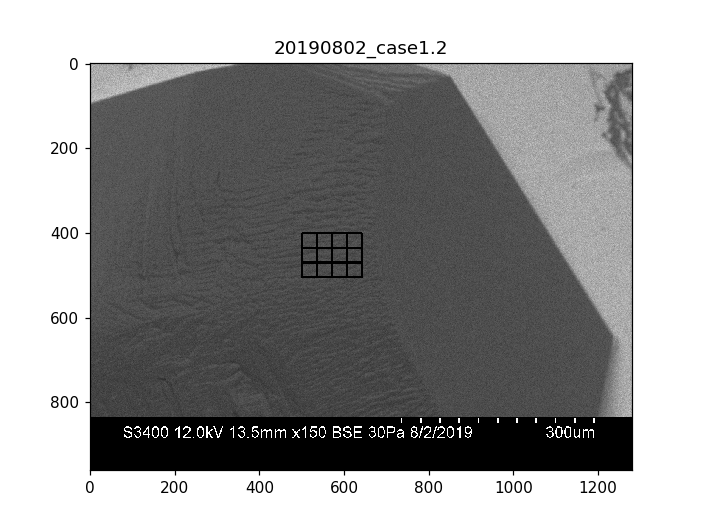

In [16]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [17]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

../Case1.1 (calibration)/Calibration.nml


In [18]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [19]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [20]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [21]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [22]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [23]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [24]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 12 )
for 500 400
Observed intensities (detector B):
mean, max, min = 37.79183673469388 59.0 23.0
<diff>, std(diff), di2 = -0.4549479077899719 5.28986343223114 2294.0618065399976
<diff>, std(diff), di2 = -0.7367356579696541 4.016606737360605 24.33765765836244
<diff>, std(diff), di2 = -0.7580581664102921 3.9948669300294872 1.0779542036904712

Segment: 1 ( 2 of 12 )
for 500 435
Observed intensities (detector B):
mean, max, min = 38.68734693877551 56.0 26.0
<diff>, std(diff), di2 = -0.3137234179940535 5.32338105804072 2424.5886682444466
<diff>, std(diff), di2 = -0.4614142313142483 4.004395299962077 28.998606611218133
<diff>, std(diff), di2 = -0.4757616537000263 3.9819414984174513 1.0201901179620356
Noverlap = 36

Segment: 2 ( 3 of 12 )
for 500 470
Observed intensities (detector B):
mean, max, min = 39.243265306122446 55.0 24.0
<diff>, std(diff), di2 = -0.2439274996267066 5.233243915608007 2092.6433125515987
<diff>, std(diff), di2 = -0.4146229533318126 4.086669781436775 2

140
105


<IPython.core.display.Javascript object>


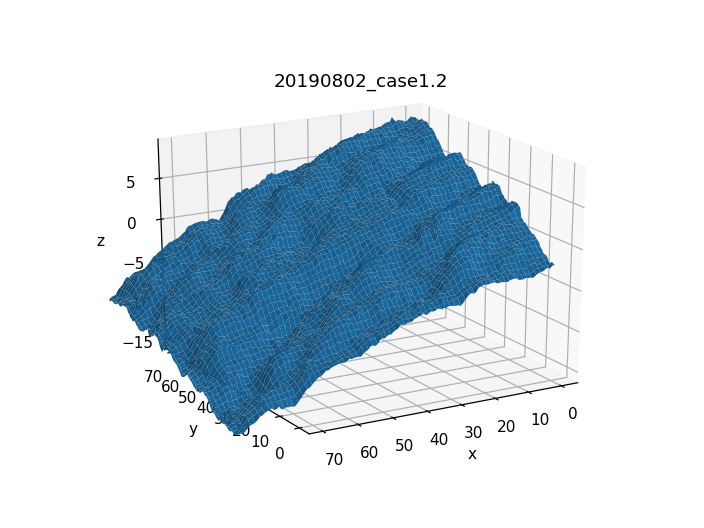

In [25]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [26]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments1_retrieved
